# Survival Analysis: Backblaze Hard Drives

Backblaze, a cloud backup service, provides one of the best public services on the internet by [periodically posting hard drive failure rates](https://www.backblaze.com/blog/category/cloud-storage/hard-drive-stats/) for the drives in their datacenter. Because they use large numbers of consumer hard drives, which are the same ones I would consider buying to use in my desktop computer, I like to consult their blog whenever I am shopping for a new one.

The key metric presented in Backblaze's blog posts, the annualized drive failure rate, is a reasonably good starting point for understanding which hard drives are more reliable than others. However, not all of Backblaze's drives are the same age, an individual drive's chance of failure may vary over its lifetime in a way that is not captured by a simple summary statistic. For example, a failure rate may hold steady at a reasonable value while the drive is under warranty, only to fail at a higher rate after it hits a certain age.

Capturing patterns like this is the domain of [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis), and in particular a visualization called the "[survival curve](https://en.wikipedia.org/wiki/Survival_function)". This is a plot of the fraction of a population that hasn't had some terminal event happen to it yet ("death" or "failure") as a function of time elapsed since some starting point. This is a commonly used technique in studies of medical patient survival rates after receiving some treatment, but equipment failure is another good application.

Backblaze commendably makes [fully granular source data](https://www.backblaze.com/b2/hard-drive-test-data.html) available in addition to the summary statistics in their blog posts. Ross Lazarus, an Australian computational biologist, used this dataset to build survival curves for hard drives in [a series of blog posts](https://bioinformare.blogspot.com/2016/02/survival-analysis-of-hard-disk-drive.html) in 2016. Reading this series was the first I had heard of a survival curve, and it seems like such a great visualization for understanding this data that I'm surprised Backblaze doesn't report it themselves. 

In this post I'll repeat Ross Lazarus' analysis using data that has been updated through Q3 2019. I also refine his technique somewhat by using Apache Spark to improve performance and expressiveness of the aggregation.

## Designing the aggregate

To construct the survival curve, we will use a [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan–Meier_estimator). This estimator builds survival curves from data in a way that handles missing data in a useful way. This is important because not every hard drive will be in the datacenter long enough to fail. For example, if a hard drive is retired from the data center after only one year to make space for one with a larger capacity, then this drive didn't fail – instead, it is "right-censored" in the data. This means we don't know exactly how long it would have taken for it to fail, but we know that it worked without failing for at least one year. Kaplan-Meier regression enables us to use this partial information to build the survival curve instead of throwing it away.

Backblaze provides a dataset that has one row per drive, per day that it operated, with a full snapshot of the drive's self-reported SMART stats on that day. For our purposes, we need only one row per drive with two pieces of information: how long it operated for and whether it failed or not. In theory, this is a straightforward aggregate to run, but because the raw dataset Backblaze provides is many gigabytes in size, it can't be run in Pandas because it can't be fit into memory. A person who wears suits to work might refer to this as a "big data" problem.

Ross Lazarus solved this by exploiting the fact that the dataset is ordered and partitioned by day. His [Python program](https://github.com/fubar2/backblazeKM) loads one day at a time and keeps track of the first and last day it observes each serial number. This is a clever approach that works pretty well, but specifying it in this way (the "imperative" style of programming) isn't as expressive as it could be using a declarative language like SQL. Using SQL, I could express our desired aggregate as

```sql
select
    manufacturer,
    model,
    serial_number,
    max(date) as retired_date,
    min(date) as launched_date,
    count(date) as observed_days,
    max(failure) as failure
from source_table
group by manufacturer, model, serial_number
```

Which I find to be a more concise description of what's going on. Unfortunately, to actually run this query, I would typically need to first load the data into a database server such as Postgres. Upon load, the database program would rewrite all that data into its internal data format, effectively making a copy of the large input dataset. Even after that cumbersome operation is done, running a SQL query might not be very fast unless I am using an analytics-optimized database implementation such as Redshift.

Apache Spark is a great goldilocks option here. Spark is an analytics framework that provides a SQL interface as well as a dataframe interface for specifying data transformations. Crucially, it can perform those transformations on data in a wide variety of formats, such as a folder full of CSVs (which is what I have).

Strictly speaking, Spark is designed to work best by distributing the work across multiple computers in a supercomputing cluster, but it also does a perfectly serviceable job distributing the work among the four processing cores in my one lonely computer. The ability to use all the cores in my processor is the key element that makes this approach faster than traversing the same data in a single-threaded Python program.

In [1]:
import os

import pandas as pd
from lifelines import KaplanMeierFitter
from humanize import naturalsize

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 160
plt.rcParams["axes.grid"] = True
plt.rcParams["savefig.bbox"] = "tight"

In [4]:
import pyspark
import pyspark.sql.functions as F
pyspark.__version__

'2.4.4'

## Loading data into Spark

To prepare for this analysis, I downloaded all the datasets from [Backblaze's site](https://www.backblaze.com/b2/hard-drive-test-data.html) using Safari, which automatically unzips them. I placed all the resulting folders into a "data" parent folder. Then I renamed each of them with the `dataset=` prefix, which is a trick that causes Spark to treat them as partitions of the same dataset when I point it at the parent folder. This can be any prefix that ends with an equals sign. I kept Backblaze's original folder names, which haven't been 100% consistent, but that doesn't matter for us.

I could also have loaded each one into spark separately and unioned them together, or chucked all the CSVs into one big folder, but this felt more expedient.

In [5]:
os.listdir('data')

['.DS_Store',
 'dataset=2013',
 'dataset=2014',
 'dataset=2015',
 'dataset=data_Q1_2016',
 'dataset=data_Q1_2017',
 'dataset=data_Q1_2018',
 'dataset=data_Q2_2016',
 'dataset=data_Q2_2017',
 'dataset=data_Q2_2018',
 'dataset=data_Q2_2019',
 'dataset=data_Q3_2016',
 'dataset=data_Q3_2017',
 'dataset=data_Q3_2018',
 'dataset=data_Q3_2019',
 'dataset=data_Q4_2016',
 'dataset=data_Q4_2017',
 'dataset=data_Q4_2018',
 'dataset=drive_stats_2019_Q1']

The uncompressed data comprise 40GB, which is much more than the amount of RAM I have. It probably would take up much less space if it were in a more efficient format such as Parquet, but for this exercise I'm trying to do my analysis on the raw files in-place.

In [6]:
!du -sh data

 40G	data


Load the data into a Spark dataframe:

In [7]:
df = spark.read.csv('data', header=True)

Unlike Pandas, this line of code doesn't put all the data into memory. Instead, Spark just peeks at the file layout and the file headers to construct a dataframe object using only the metadata. The object in memory only makes reference to the files on disk; it hasn't looked at the contents yet.

Operations on the actual data will be evaluated "lazily", meaning Spark will put them on a to-do list and defer them until we actually need to know something definite about the result (such as counting the number of rows it has, or loading it into Pandas). When it comes time to actually do the work, Spark delegates the job of actually looking in the CSV files to a set of executor processes.

## Data cleaning

I select only the columns that we will be using, trim whitespace, and cast them to the correct data types:

In [8]:
dff = df.select(
    F.col("date").astype("date"),
    F.trim(F.col("serial_number")).alias("serial_number").astype("string"),
    F.trim(F.col("model")).alias("model").astype("string"),
    F.col("capacity_bytes").astype("bigint"),
    F.col("failure").astype("int"),
    F.col("smart_9_raw").astype("bigint"),
    F.col("dataset").astype("string"),
)

Lazy evaluation means that none of this work actually happened yet, so if there are errors I won't know until later. The `limit` method is a good way to test that things will work using only the first few rows of data.

In [9]:
dff.limit(10).toPandas()

,date,serial_number,model,capacity_bytes,failure,smart_9_raw,dataset
0,2019-09-27,Z305B2QN,ST4000DM000,4000787030016,0,33165,data_Q3_2019
1,2019-09-27,ZJV0XJQ4,ST12000NM0007,12000138625024,0,10203,data_Q3_2019
2,2019-09-27,ZJV0XJQ3,ST12000NM0007,12000138625024,0,7234,data_Q3_2019
3,2019-09-27,ZJV0XJQ0,ST12000NM0007,12000138625024,0,10803,data_Q3_2019
4,2019-09-27,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,23239,data_Q3_2019
5,2019-09-27,ZA16NQJR,ST8000NM0055,8001563222016,0,21118,data_Q3_2019
6,2019-09-27,ZJV02XWG,ST12000NM0007,12000138625024,0,12147,data_Q3_2019
7,2019-09-27,ZJV1CSVX,ST12000NM0007,12000138625024,0,10460,data_Q3_2019
8,2019-09-27,ZJV02XWA,ST12000NM0007,12000138625024,0,12133,data_Q3_2019
9,2019-09-27,ZA18CEBS,ST8000NM0055,8001563222016,0,18091,data_Q3_2019


I also want to add a "manufacturer" column based on string-parsing the model column. While I'm at it, I consolidate HGST with Hitachi, since those are two names for the same manufacturer.

In [10]:
dfm = dff.withColumn(
    "manufacturer",
    F.when(F.col("model").like("ST%"), "Seagate")
    .when(F.col("model").like("Hitachi %"), "HGST/Hitachi")
    .when(F.col("model").like("HGST %"), "HGST/Hitachi")
    .when(F.col("model").like("% %"), F.split(F.col("model"), " ")[0])
    .otherwise("unknown"),
)

The logic above adds a column to the dataframe using logic equivalent to a SQL `CASE` statement, which is a neat thing that is easier to do in Spark than in Pandas.

## Data aggregation

To write my aggregate using SQL, I first need to make the dataframe available in the Spark SQL context.

In [11]:
dfm.createOrReplaceTempView('drive_days')

Now it's time to write the aggregation query. There are some quirks in the data that I need to code around.

 - According to the documentation, the `failure` flag is supposed to be set to 1 on the last day that the drive was operating. But I found examples where the drive is marked as failed but continues to operate for many days later, sometimes with the flag set back to zero. Maybe this means the drive didn't really fail, but to be safe I treat a drive as failed if it ever had this flag set on any day (`max(failure) as failure`). I also record the date that the failure flag first appeared (`min(case when failure=1 then date end) as failed_date`) instead of relying on that to be the same as `max(date)`.
 - In theory, all drives of the same model should have the same capacity. But the `capacity_bytes` of some drives is sometimes missing for a day (marked as `-1` in the data), but available for other days. This means we can't safely group by this column. I select `max(capacity_bytes) as capacity_bytes` instead. 
 - The number of hours a drive has been operating (`smart_9_raw`) could be useful in this analysis, but is self-reported by the drive so may have errors that I haven't cleaned up. I include it in this aggregate even though I don't plan to use it for this.
 
The query I wrote is similar to the one I quoted earlier in the post:

In [12]:
drive_spans = spark.sql("""
select
    manufacturer,
    model,
    serial_number,
    max(date) as retired_date,
    min(date) as launched_date,
    count(date) as observed_days,
    max(capacity_bytes) as capacity_bytes,
    min(case when failure=1 then date end) as failed_date,
    max(smart_9_raw) as max_hours,
    min(case when failure=1 then smart_9_raw end) as failed_hours,
    max(failure) as failure
from drive_days
group by manufacturer, model, serial_number
""").cache()

This code defines our big, slow aggregate in terms of the SQL query, but doesn't actually perform any calculations until we perform some action on the resulting dataframe (because of lazy evaluation).

If we expect to do more than one thing with the `drive_spans` dataframe, it's a good idea to use the `.cache()` suffix, which effectively establishes a checkpoint in the chain of lazy evaluation. This tells Spark to save the result in memory or in a temp file so that repeated actions on the dataframe don't result in Spark having to start all over from the un-aggregated data each time.

I run a `count()` to actually do the aggregate:

In [13]:
%%time
drive_spans.count()

CPU times: user 33.6 ms, sys: 15.6 ms, total: 49.2 ms
Wall time: 5min 30s


173209

This took ~5 minutes on my quad-core Ivy Bridge desktop. With irrelevant details aggregated out, it's now small enough to load into Pandas.

The `.cache()` only lasts as long as I have this Spark session open. Because that took so long, I'm saving the output as a parquet file so that I can load it later instead of re-aggregating the raw data.

In [14]:
drive_spans.write.mode('overwrite').parquet('drive_spans')

Between aggregating out data I don't need and converting to Parquet, I've reduced the data size down from many GB to a couple MB.

In [15]:
!du -sh drive_spans

5.5M	drive_spans


It's small enough to load into Pandas now, but there's a few more things I want to do with this in Spark.

## Context setting: What drives are in the datacenter?

Before doing survival analysis, I want to get a read on what drives have been in Backblaze's portfolio over time. The simplest way of doing this would involve another aggregate over the raw data (grouping by manufacturer and date). To avoid doing another pass over the ~40 GB of source files, I can use my existing aggregate by joining it to a date backbone with a fancy join condition:

In [16]:
drive_spans.createOrReplaceTempView('drive_spans')

mfr_weeks = spark.sql("""
select
    date,
    manufacturer,
    count(distinct serial_number) as n_drives
from
(select explode(sequence(
    to_date('2013-01-01'),
    to_date('2023-01-01'),
    interval 1 week
    )) as date
) backbone
inner join drive_spans
  on backbone.date
      between drive_spans.launched_date
          and drive_spans.retired_date
group by date, manufacturer
""").cache()


Note that the way I'm doing this assumes that drives don't get cycled out and then back in again. If Backblaze is swapping out cold spares, the above won't work – I'll need to do another pass over the raw source in some way that captures this.

Load it from Spark into Pandas:

In [17]:
%%time
pd_mfr_weeks = mfr_weeks.toPandas().assign(
    date=lambda x: pd.to_datetime(x.date)
)

CPU times: user 19.5 ms, sys: 4.55 ms, total: 24 ms
Wall time: 23.1 s


Construct a "wide" dataframe for plotting in Pandas. I'm filtering out manufacturers that didn't have very many drives.

In [18]:
pdcounts = pd_mfr_weeks.groupby("manufacturer").n_drives.max()

pdp = pd_mfr_weeks.pivot(
    index="date", columns="manufacturer", values="n_drives"
).loc[:, pdcounts > 30]

pdp.head()

manufacturer,DELLBOSS,HGST/Hitachi,Seagate,TOSHIBA,WDC
date,,,,,
2013-04-16,NaN,12216.0,8198.0,40.0,1309.0
2013-04-23,NaN,12215.0,8241.0,41.0,1312.0
2013-04-30,NaN,12304.0,8198.0,43.0,1310.0
2013-05-07,NaN,12305.0,8198.0,43.0,1310.0
2013-05-14,NaN,12349.0,8285.0,47.0,1310.0


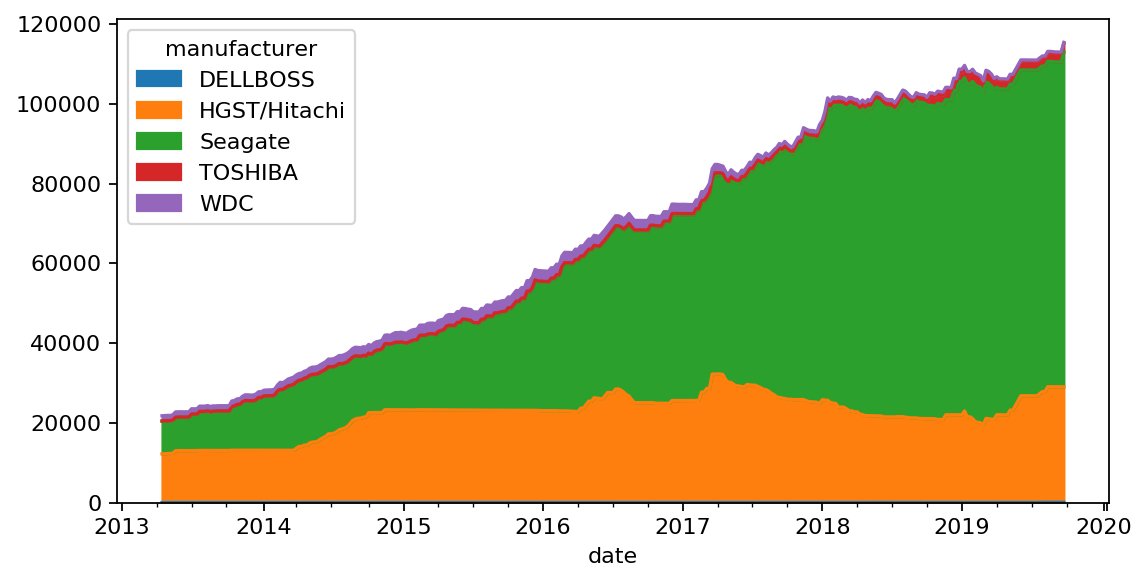

In [19]:
pdp.plot.area()
plt.grid(False)

It's clear that Seagate drives are the main ingredient in Backblaze's storage system, with a side of HGST. Other manufacturers are just for seasoning. It's hard to tell what the others are, so I plot this on a log scale:

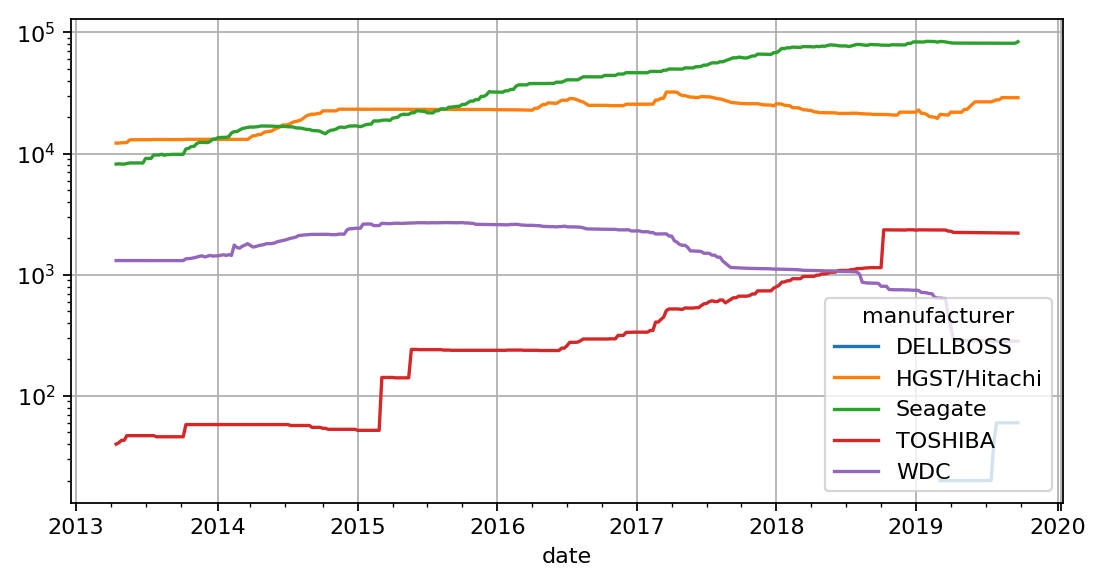

In [20]:
pdp.plot(logy=True)

Backblaze used to have many more Western Digital (WDC) drives, but has drawn those down in favor of Seagate, HGST, and Toshiba.

## Survival analysis

To do my survival analysis, I need to add a few more columns to the aggregate.

 - The number of days the drive lasted: difference between the max and min dates that the drive was seen in the data center. I use `coalesce` to use the failure date when it exists, with the max observed date as a fallback, to handle cases when the drive failed several days before being removed.
 - Some drive model-level metadata that I'll use for context / ordering. I use a window function to calculate:
    - the date that any drive of this model was first introduced to the datacenter
    - storage capacity of the model. I need to do this because of glitches at the indivdual-drive level. Because the capacity of individual drives can be anomalously high and low, I use the median as the aggregate function rather than max or min.

Window functions are a handy way to attach per-model summary stats to this dataset while keeping it at the serial-number granularity.

In [21]:
dfsurv = spark.sql("""
select
    drive_spans.*,
    datediff(coalesce(failed_date, retired_date), launched_date) as duration,
    min(launched_date) over (partition by model) as model_introduced,
    percentile_approx(capacity_bytes, 0.5) over (partition by model order by capacity_bytes) as model_capacity
from drive_spans
""")

Take a peek at the final datasource format:

In [22]:
dfsurv.limit(10).toPandas()

,manufacturer,model,serial_number,retired_date,launched_date,observed_days,capacity_bytes,failed_date,max_hours,failed_hours,failure,duration,model_introduced,model_capacity
0,Seagate,ST9250315AS,S2X6BE9Z,2018-06-14,2014-02-14,1569,250059350016,None,41109,NaN,0,1581,2014-01-29,250059350016
1,Seagate,ST9250315AS,S2X6BYB6,2018-07-03,2014-02-14,1588,250059350016,None,40167,NaN,0,1600,2014-01-29,250059350016
2,Seagate,ST9250315AS,S2X3XJ5Y,2015-06-01,2014-02-14,468,250059350016,2015-06-01,13958,13958.0,1,472,2014-01-29,250059350016
3,Seagate,ST9250315AS,S2X6AD6A,2018-06-09,2014-02-14,1570,250059350016,None,40079,NaN,0,1576,2014-01-29,250059350016
4,Seagate,ST9250315AS,S2X6CLBK,2018-02-07,2014-02-14,1402,250059350016,None,36155,NaN,0,1454,2014-01-29,250059350016
5,Seagate,ST9250315AS,S2X4PP5Q,2018-04-21,2014-02-14,1492,250059350016,None,40534,NaN,0,1527,2014-01-29,250059350016
6,Seagate,ST9250315AS,S2X6BYHJ,2018-06-15,2014-02-14,1571,250059350016,None,40079,NaN,0,1582,2014-01-29,250059350016
7,Seagate,ST9250315AS,S2X6CG2C,2018-04-17,2014-02-14,1510,250059350016,None,39775,NaN,0,1523,2014-01-29,250059350016
8,Seagate,ST9250315AS,S2X6BYH6,2018-08-18,2014-02-14,1635,250059350016,None,41272,NaN,0,1646,2014-01-29,250059350016
9,Seagate,ST9250315AS,S2X6CEJM,2017-09-06,2014-02-14,1189,250059350016,None,30491,NaN,0,1300,2014-01-29,250059350016


Now select the columns we need for the analysis and load them into Pandas.

In [23]:
%%time

pdsurv = (
    dfsurv.select(
        "serial_number",
        "manufacturer",
        "model",
        "model_introduced",
        "model_capacity",
        "launched_date",
        "duration",
        "failure",
    )
    .toPandas()
    .assign(
        launched_date=lambda x: pd.to_datetime(x.launched_date),
        model_introduced=lambda x: pd.to_datetime(x.model_introduced),
    )
    .set_index("serial_number")
)

CPU times: user 1.91 s, sys: 93.1 ms, total: 2 s
Wall time: 4.97 s


In [24]:
pdsurv.head()

,manufacturer,model,model_introduced,model_capacity,launched_date,duration,failure
serial_number,,,,,,,
S2X6BE9Z,Seagate,ST9250315AS,2014-01-29,250059350016,2014-02-14,1581,0
S2X6BYB6,Seagate,ST9250315AS,2014-01-29,250059350016,2014-02-14,1600,0
S2X3XJ5Y,Seagate,ST9250315AS,2014-01-29,250059350016,2014-02-14,472,1
S2X6AD6A,Seagate,ST9250315AS,2014-01-29,250059350016,2014-02-14,1576,0
S2X6CLBK,Seagate,ST9250315AS,2014-01-29,250059350016,2014-02-14,1454,0


Now it's time to fit and plot the KM survival curve. I'm using the [lifelines](https://lifelines.readthedocs.io/en/latest/index.html) Python module, but you could also switch to R here and use the [survival](https://cran.r-project.org/web/packages/survival/) or [survminer](https://cran.r-project.org/web/packages/survminer/index.html) packages.

In [25]:
YEARS = 365.25

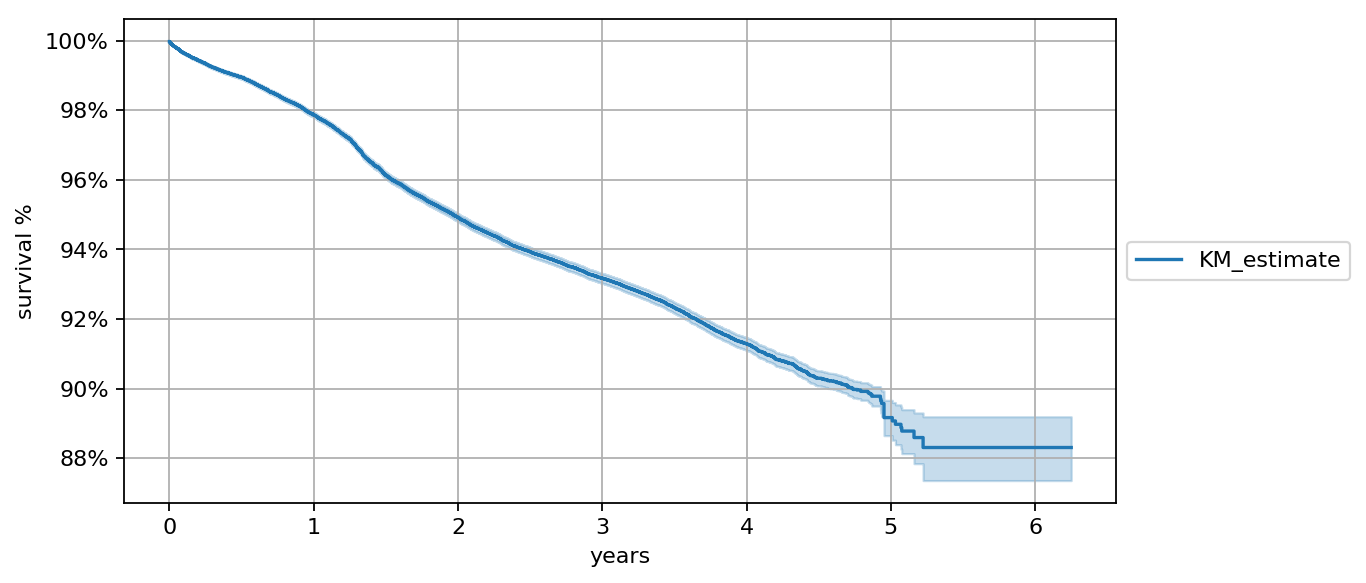

In [26]:
kmf = KaplanMeierFitter()
kmf.fit(pdsurv.duration / YEARS, event_observed=pdsurv.failure)
ax = kmf.plot()

ax.set_xlabel("years")
ax.set_ylabel("survival %")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

The survival curve shows the percentage of drives surviving after a given period of use. We can read the failure rate off as the slope of the curve: about 2% per year. The curve is more or less linear, indicating that the drives Backblaze is buying fail at a more or less constant rate overall.

We do see a steep drop, and a broadening of the confidence interval, at the five-year mark. But few drives have been in the datacenter that long (and the full dataset barely spans a 6 year period) so I wouldn't read too much into it.

It is more interesting to break this down by manufacturer:

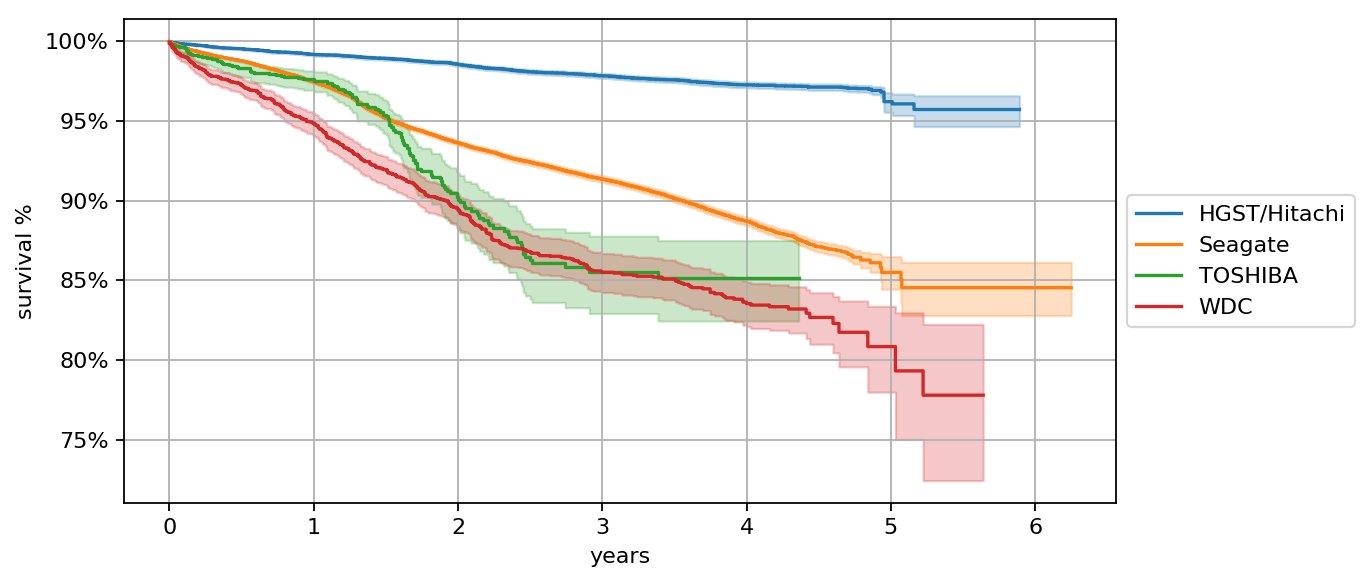

In [27]:
ax = plt.gca()

for name, grouped_df in pdsurv.groupby("manufacturer"):

    if len(grouped_df) < 100:
        # skip small sample manufacturers
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(grouped_df.duration / YEARS, grouped_df.failure, label=name)
    kmf.plot(ax=ax)

ax.set_xlabel("years")
ax.set_ylabel("survival %")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.savefig("images/manufacturers.png")

A real disparity is evident here between the expensive HGST drives and the consumer grade drives such as Seagate, Western Digital and Toshiba. The enterprise drives have less than 5% failure rate even after 4 years, whereas the consumer drives all exceed that rate before their second year of use.

The curve for Toshiba is very interesting because it grows steeper and then levels off. This may indicate that these drives had a problem that caused some of them to wear out at a faster rate after a year and a half of use. The fact that the curve levels back out could indicate that reliability improves after the bad apples fail their way out of the population.

Making inferences at the drive brand level is not really that actionable as a consumer since a lot of these behaviors are specific to the individual model of drive. Let's look at individual models of Seagate drives.


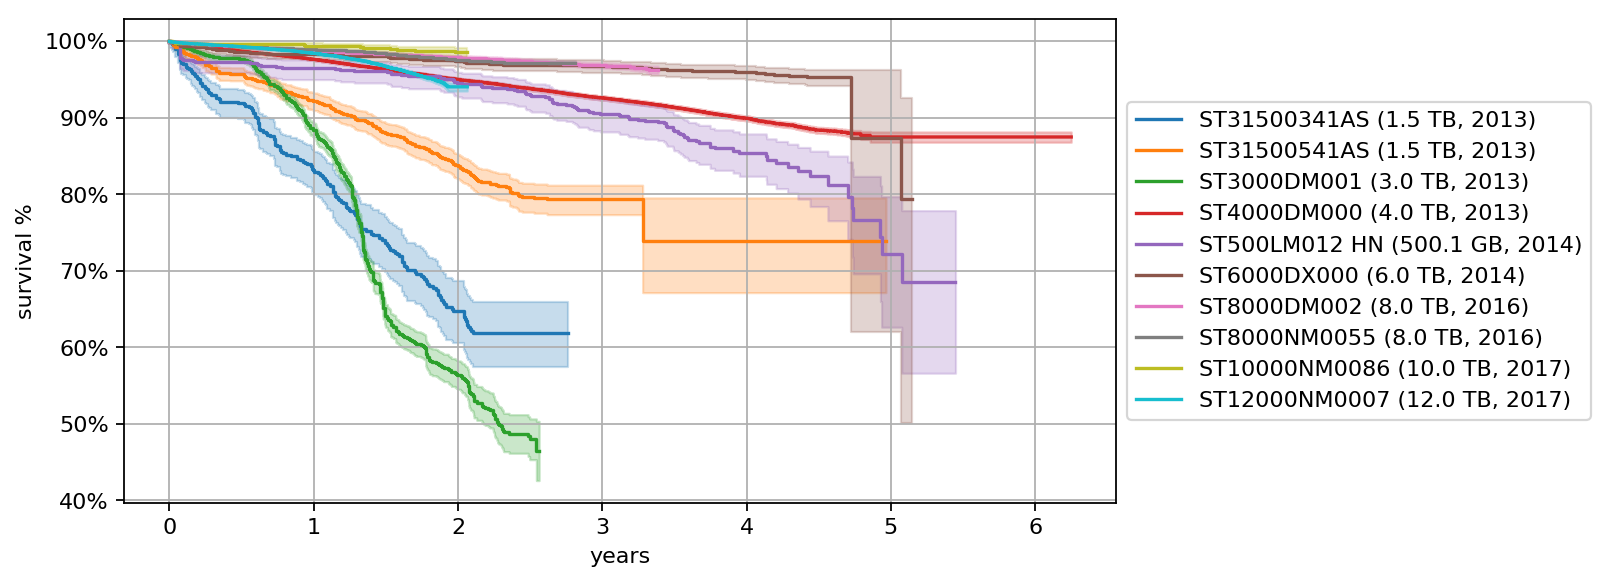

In [28]:
ax = plt.gca()

mask = pdsurv.manufacturer == "Seagate"
gcols = ["model_introduced", "model_capacity", "model"]

for group, grouped_df in pdsurv[mask].groupby(gcols):

    model_introduced, model_capacity, model = group

    if len(grouped_df) < 500:
        # skip small sample groups
        continue

    label = "{} ({}, {})".format(
        model, naturalsize(model_capacity), model_introduced.year
    )

    kmf = KaplanMeierFitter()
    kmf.fit(grouped_df.duration / YEARS, grouped_df.failure, label=label)
    kmf.plot(ax=ax)

ax.set_xlabel("years")
ax.set_ylabel("survival %")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.savefig("images/seagate.png")

There are a couple things to learn here. First of all, 2013 was a dark time for hard drives – prices were high and quality was low. The 3TB Seagates were so bad that Backblaze published [a special episode](https://www.backblaze.com/blog/3tb-hard-drive-failure/) of their hard drive series devoted entirely to discovering what was going on. I myself had one of these drives fail in my computer, which is part of what radicalized me into running statistical analyses on hard drive data.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">lol guess which hard drive i bought in 2012 <a href="https://t.co/xSPOOfvQvJ">https://t.co/xSPOOfvQvJ</a> <a href="https://twitter.com/Seagate?ref_src=twsrc%5Etfw">@seagate</a> <a href="https://twitter.com/backblaze?ref_src=twsrc%5Etfw">@backblaze</a> <a href="http://t.co/6eQEfxTPO4">pic.twitter.com/6eQEfxTPO4</a></p>&mdash; Tom Baldwin (@umhecbaa) <a href="https://twitter.com/umhecbaa/status/603937386406379520?ref_src=twsrc%5Etfw">May 28, 2015</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

One caveat worth mentioning here is that our dataset begins in 2013, so any drive that was in the datacenter when the first day of the dataset was recorded is technically left-censored. I am not correcting for this here, which may lead to some bias in the curves for older drives. See [this page](http://bl.ocks.org/nstrayer/4e613a109707f0487da87300097ca502) for an example of the perils of left-censored data in Kaplan-Meier fitting.

Viewing the survival plot at the full scale makes it hard to see the drives that you would actually buy in 2019, since those have shorter histories. Zoom in to the upper left corner to get a look at how the new drives are doing:

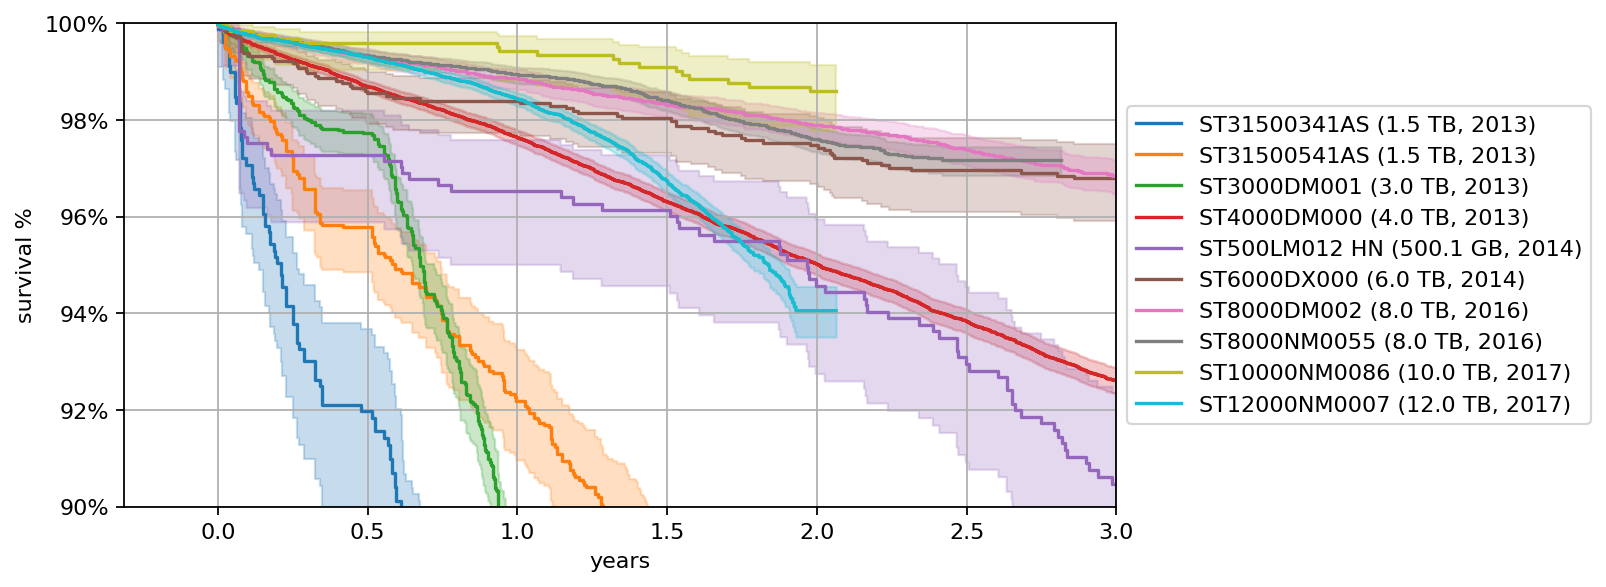

In [29]:
ax.set_xlim(right=3)
ax.set_ylim(top=1, bottom=.9)
ax.figure

Overall, it seems that drive reliability has gotten much better than the dark days of 2013. The 6TB and 8TB Seagates have had much better reliability than any of the drives that came before. It's probably due to substantial quality improvements at Seagate, but changes to the operating conditions in the Backblaze datacenter may have also contributed (e.g., better-cooling storage pods).

Recently Backblaze has been testing 10TB and 12TB drives, and it seems like the 10TB drives are doing substantially better than the 12 TB ones. Personally, I'd steer clear of the latter since I'm not exactly hurting for the extra 20%. The 12TB survival curve is sloping more steeply downward of late, which would fill me with a sense of foreboding if I owned this drive.

## Summary

Performing survival analysis is a fun exercise that's well-suited to this dataset. Spark is a relatively expressive tool for getting data boiled down to a size where we can work with it. It's pretty performant, too – crunching through the ~40 GB source data took only five minutes using my seven-year-old computer.

It's also nice to learn that hard drive quality has apparently improved in the past few years. Of course, it's important to keep it all in perspective: *no* hard drive is 100% reliable, and *all* hard drives will eventually fail. We can use analyses like this to inform ourselves and hopefully reduce our risk, but we can always expect to suffer loss of a disk at some time. Keep making those backups!

## DIY

The code for this analysis is available as a [Jupyter notebook](https://github.com/baldwint/backblaze-survival). It could be further extended in many ways:

 - by looking at the other manufacturers that Backblaze buys lots of drives from (HGST and Toshiba)
 - by looking at cohorts of the same drive model
 - by using the drive's self-reported hours figure to determine duration
 
I've left these as an exercise for the reader. Happy analyzing!